In [16]:
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np 
import seaborn as sns
import os, sys
from hsbmpy import get_file, define_labels, get_cluster_given_l, get_max_available_L
from geneontology import topic_analysis
import tensorflow as tf
from sklearn.metrics import homogeneity_completeness_v_measure
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from lda import lda
sys.path.append('/home/fvalle/phd/master_thesis/hsbm/')
sys.path.append('/home/fvalle/phd/master_thesis/')

In [17]:
os.chdir("/home/fvalle/phd/")

In [18]:
level = 2
#setup = 'oversigma_10tissue'
#label = 'disease_type'
label='lda'
#label = 'uniq'
#labels = ['primary_site', 'disease_type']
#labels = ['primary_site', 'secondary_site']
directory=r"datasets/gtex/log/3000_random-5000hvg"
#L=get_max_available_L(directory)
os.chdir(directory)

In [19]:
df = pd.read_csv("mainTable.csv", index_col=[0], header=[0]).dropna().astype(int)
totalobjcets = len(df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, ENSG00000038945 to ENSG00000125967
Columns: 3000 entries, GTEX-16NPV-0011-R8a-SM-7EPH8 to GTEX-S32W-1326-SM-4AD5Q
dtypes: int64(3000)
memory usage: 114.5+ MB


In [33]:
df_files = pd.read_csv("files.dat", index_col=[0])
df_files.head()

,SMTS,SMTSD
GTEX-16NPV-0011-R8a-SM-7EPH8,Brain,Brain - Hypothalamus
GTEX-U8T8-0126-SM-3DB94,Skin,Skin - Sun Exposed (Lower leg)
GTEX-12ZZW-0011-R5a-SM-5DUVN,Brain,Brain - Caudate (basal ganglia)
GTEX-11TT1-1926-SM-5PNYN,Adipose Tissue,Adipose - Visceral (Omentum)
GTEX-T6MN-1226-SM-3NMA5,Liver,Liver


In [6]:
df = df.applymap(lambda x: np.log(x+1))

In [35]:
true_out = []
for sample in df.columns.values:
    try:
        true_out.append(get_file(sample, df_files[~df_files.index.isna()])['SMTS'])
    except:
        print(*sys.exc_info())
        true_out.append('unknown')

In [36]:
scores = {}

In [37]:
try:
    with open("clustersizes.txt",'r') as f:
        xl = np.array(f.read().split(sep='\n'))[:-1].astype(int)
except:
        xl=np.linspace(2,50,5, dtype=int)
xl

array([112,  32,  12,   3])

In [ ]:
xl = np.concatenate([xl, np.logspace(1,2,5)])

In [ ]:
xl = np.sort(xl).astype(int)
xl

In [ ]:
df.T.values.shape

## hierarchical

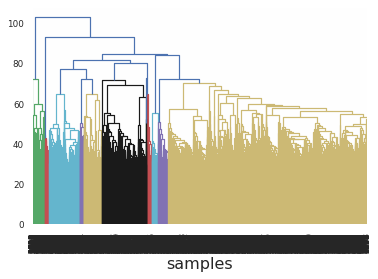

In [38]:
fig=plt.figure()
dend = shc.dendrogram(shc.linkage(df.T.values, method='average'), leaf_rotation=90., leaf_font_size=8.,)
plt.xlabel("samples", fontsize=16)
plt.show()
fig.savefig("hierarchical_dendogram.pdf")

In [ ]:
#hierarchical
scores['hierarchical']={
    'h':[],
    'c':[],
    'V':[]
}
def pearson_affinity(M, parallel=True):
    return 1 - np.array([[pearsonr(a,b)[0] for a in M] for b in M])

print("hierarchical")
os.system('mkdir -p hierarchical')
hierarchical_model = AgglomerativeClustering(n_clusters=1, affinity=pearson_affinity, linkage='complete')  
for l,x in enumerate(xl[:]):
    print("testing with %d clusters"%x)
    hierarchical_model.n_clusters=x
    data = df.T.values
    out = hierarchical_model.fit_predict(data)
        
    #save clusters
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(len(df.columns)))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df.columns[np.argwhere(out==c)].values.T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(len(df.columns)-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierarchical/hierarchical_level_%d_clusters.csv"%(l), index=False, header=True)

hierarchical
testing with 112 clusters
saving clusters
testing with 32 clusters


## LDA

In [40]:
with open("topicsizes.txt",'r') as f:
    tl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

In [41]:
print(xl, tl)

[112  32  12   3] [1358  562  104   14]


In [ ]:
xl = xl[2:]
tl = xl
Sigmas = []

In [42]:
model=lda(n_jobs=1, verbose=2)
model.full_analysis(os.getcwd(), xl,tl=None, label='SMTS')

model created
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, ENSG00000237683 to ENSG00000251322
Columns: 3000 entries, GTEX-16NPV-0011-R8a-SM-7EPH8 to GTEX-S32W-1326-SM-4AD5Q
dtypes: int64(3000)
memory usage: 68.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4032 entries, GTEX-U412-0726-SM-EVR2Y to nan
Data columns (total 62 columns):
SMATSSCR     2373 non-null float64
SMCENTER     2999 non-null object
SMPTHNTS     2373 non-null object
SMRIN        3000 non-null float64
SMTS         3000 non-null object
SMTSD        3000 non-null object
SMUBRID      3000 non-null object
SMTSISCH     2999 non-null float64
SMTSPAX      2369 non-null float64
SMNABTCH     3000 non-null object
SMNABTCHT    3000 non-null object
SMNABTCHD    3000 non-null object
SMGEBTCH     2999 non-null object
SMGEBTCHD    2998 non-null object
SMGEBTCHT    3000 non-null object
SMAFRZE      3000 non-null object
SMGTC        0 non-null float64
SME2MPRT     3000 non-null float64
SMCHMPRS     3000 non-null 

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type 'float' is not iterable
argument of type

testing with 112 clusters and 112 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 1 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 3 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 4 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


saving word-distr
saving topic-distr
<class 'ValueError'> Can't convert non-rectangular Python sequence to Tensor. <traceback object at 0x7f7cf5ddbcc8>
saving clusters
saving metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


testing with 32 clusters and 32 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 1 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 3 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 4 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


saving word-distr
saving topic-distr
<class 'ValueError'> Can't convert non-rectangular Python sequence to Tensor. <traceback object at 0x7f7cf5dd5e48>
saving clusters
saving metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


testing with 12 clusters and 12 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 1 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 3 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 4 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


saving word-distr
saving topic-distr
<class 'ValueError'> Can't convert non-rectangular Python sequence to Tensor. <traceback object at 0x7f7cf5dd5508>
saving clusters
saving metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


testing with 3 clusters and 3 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 1 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 3 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 4 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


saving word-distr
saving topic-distr
<class 'ValueError'> Can't convert non-rectangular Python sequence to Tensor. <traceback object at 0x7f7cf5dece88>
saving clusters
saving metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


In [ ]:
fig, ax=plt.subplots(figsize=(20,10))
for topic in df_D.columns:
    df_D[topic].hist(ax=ax, histtype='step', density=True, lw=2, label=topic)
ax.set_yscale('log')
ax.set_xlabel('$D^g[k]$', fontsize=20)
plt.tick_params(labelsize=20)
plt.tick_params(axis='x', rotation=60)
ax.legend(ncol=5)
plt.show()
fig.savefig("%s/distinctivness.pdf"%directory)

In [ ]:
topic_analysis(directory,1, 'lda')

In [ ]:
Sigmas

In [ ]:
homogeneity_completeness_v_measure(true_out, out)

## LDA Mallet

In [ ]:
from gensim.models.wrappers import LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import get_tmpfile
from gensim.corpora import MmCorpus

In [ ]:
corpus=list(map(list,map(lambda x: list(zip(range(len(df.index)), df[x])),df.columns)))
corpus

In [ ]:
dictionary=Dictionary([df.index])
[a for a in dictionary.items()]

In [ ]:
out_file=get_tmpfile("/home/fvalle/phd/datasets/tcga/oversampling_10tissue/corpus.mm")
MmCorpus.serialize(out_file, corpus, dictionary)

In [ ]:
model = LdaMallet("/home/fvalle/phd/Mallet/bin/mallet", workers=5, corpus=corpus, num_topics=15, id2word=dictionary)

In [ ]:
df_topics=pd.DataFrame(data=model.get_topics().T, index=[a[1] for a in dictionary.items()], columns=["Topic %d"%(t+1) for t in range(5)])
df_topics

In [ ]:
df_topic_distr=pd.read_csv(model.fdoctopics(), sep='\t', header=None, index_col=0).drop(1,1)
df_topic_distr.columns=["Topic %d"%(t+1) for t in range(5)]
df_topic_distr.index=df.columns
df_topic_distr

In [ ]:
df_topic_distr.apply(lambda x: x.idxmax().split(" ")[1], axis=1)

## hierachical on Altmann's output

In [ ]:
hiermodel = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')

In [ ]:
with open('clustersizes.txt') as f:
    xl=np.array(f.read().split('\n')[:-1]).astype(int)

In [ ]:
os.system("mkdir -p hierhsbm")

In [ ]:
true_out = []
for sample in pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',0), index_col=1).drop('i_doc', axis=1).index.values:
    try:
        true_out.append(get_file(sample, df_files)['primary_site'])
    except:
        print(sys.exc_info()[0])
        true_out.append('')

In [ ]:
scores['hierhsbm']={
    'h':[],
    'c':[],
    'V':[]
}
for l,n_clusters in enumerate(xl):
    print("Fitting level %d with %d clusters"%(l, n_clusters))
    df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',l), index_col=1).drop('i_doc', axis=1)
    df_clusters = pd.DataFrame(columns=["Cluster %d"%c for c in np.arange(n_clusters)+1])
    hiermodel.n_clusters=n_clusters
    out = hiermodel.fit_predict(df_topics.values)  
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df_topics.index[np.argwhere(out==c)].values.T[0]
        df_clusters["Cluster %d"%(c+1)]=np.concatenate((c_objects,[np.nan for _ in np.arange(len(df_topics.index)-len(c_objects))]))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierhsbm/hierhsbm_level_%d_clusters.csv"%(l), index=False, header=True)
    #metrics
    print("saving metrics")
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['hierhsbm']['h'].append(score[0])
    scores['hierhsbm']['c'].append(score[1])
    scores['hierhsbm']['V'].append(score[2])
    
pd.DataFrame(data=scores['hierhsbm']).to_csv("%s/hierhsbm.scores"%directory, header=True, index=False)

## Topic mapping

In [ ]:
df_clusters = pd.read_csv("tm/tm_level_0_clusters.csv")

In [ ]:
out=[]
true_out=[]
for c in df_clusters.columns:
    for sample in df_clusters[c].dropna():
        out.append(c)
        true_out.append(get_file(sample, df_files)['primary_site'])

In [ ]:
score = (*homogeneity_completeness_v_measure(true_out, out), len(df_clusters.columns))
    
pd.DataFrame(data=score, index=['h','c','v', 'n']).transpose().to_csv("%s/tm.scores"%directory, header=True, index=False)

# t-SNE

## WGCNA

In [ ]:
df_wgcna = pd.read_csv("wgcna/wgcna_level_0_labels.csv", index_col=0)

In [ ]:
out = df_wgcna['x'].values

In [ ]:
print("saving clusters")
df_clusters = pd.DataFrame(index=np.arange(totalobjcets))
for c in np.arange(out.max())[::-1]:
    c_objects = df.columns[np.argwhere(out==(c+1))].values.T[0]
    df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(totalobjcets-len(c_objects))])))
df_clusters.dropna(axis=0,how='all', inplace=True)
df_clusters.to_csv("wgcna/wgcna_level_0_clusters.csv", index=False, header=True)

## hSBM

In [ ]:
from sbmtm import sbmtm
from graph_tool.spectral import adjacency
import pickle

In [ ]:
with open("topsbm/topsbm.pkl", 'rb') as file:
    hsbm = pickle.load(file)

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz', skiprows=2, compression='gzip', sep='\t')
df_files=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)
df.set_index('Name', inplace=True)
df=df.drop(['Description'],1)

In [ ]:
df.head()

In [ ]:
df = df.reindex(index=hsbm.words, columns=hsbm.documents).dropna(how='all', axis=1).dropna(how='all', axis=0)

In [ ]:
for doc in df.columns:
    if 'GTEX-1GZ2Q' in doc:
        print(doc)

In [ ]:
df = df.applymap(lambda x: np.log(x+1))
df.to_csv("mainTable.csv", index=True, header=True)